<a href="https://www.kaggle.com/code/shravankumar147/qwen2-vl-2b-instruct-single-gpu?scriptVersionId=207923292" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Step 1: Install Necessary Libraries
```python
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils quanto accelerate 
# flash-attn
```
Install Hugging Face's Transformers library and supporting utilities for working with the Qwen-VL model, including `qwen-vl-utils` for vision-language processing and `accelerate` for efficient multi-device execution.

---

In [1]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils  quanto accelerate 
# flash-attn

### Step 2: Import Required Modules
```python
import os
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from accelerate import init_empty_weights, infer_auto_device_map
from qwen_vl_utils import process_vision_info
```
Import necessary modules for environment management, model loading, and processing images and text.

---

In [2]:
import os
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from accelerate import init_empty_weights, infer_auto_device_map
from qwen_vl_utils import process_vision_info
from IPython.display import Image

### Step 3: Optimize CUDA Memory Usage
```python
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
```
Set environment variables to enable dynamic CUDA memory allocation, improving memory efficiency for large models.

---

In [3]:
# Set Environment Variables for Better CUDA Memory Management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

### Step 4: Load and Configure the Model
#### Initialize the Model with Empty Weights
```python
with init_empty_weights():
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-2B-Instruct",
        torch_dtype="auto"  # Use automatic precision
    )
```
Load the model in a memory-efficient manner by initializing weights only when needed.


#### Create a Device Map for Multi-GPU Support
```python
device_map = infer_auto_device_map(
    model, max_memory={0: "7GiB", 1: "7GiB", "cpu": "15GiB"}
)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    device_map=device_map,
    torch_dtype=torch.bfloat16,  # Use memory-efficient bfloat16 precision
)
```
Automatically distribute the model across multiple GPUs and the CPU based on available memory.

In [4]:
# Load Model with Accelerated Multi-GPU Device Mapping
print("Loading model...")
with init_empty_weights():
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-2B-Instruct",
        torch_dtype="auto"  # Use automatic precision
    )

# 1 GPU
device_map = infer_auto_device_map(
    model, max_memory={0: "7GiB", "cpu": "15GiB"}
)

# 2 GPUs 
# device_map = infer_auto_device_map(
#     model, max_memory={0: "7GiB", 1: "7GiB", "cpu": "15GiB"}
# )

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    device_map=device_map,
    torch_dtype=torch.bfloat16,  # Use memory-efficient bfloat16 precision
)

Loading model...


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

---

### Step 5: Load the Processor and Set Image Constraints
```python
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", 
    min_pixels=256*28*28, max_pixels=1024*28*28
)
```
Configure the processor for handling input images, setting minimum and maximum pixel sizes for pre-processing.

---

In [5]:
# Load Processor and Configure Image Token Range
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=256*28*28, max_pixels=1024*28*28)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Step 6: Define Inputs for Image Captioning
#### Specify Input Image URL
```python
input_image_url = "https://t4.ftcdn.net/jpg/09/22/14/31/360_F_922143188_z2PQRcdhGUUGogaEPPVGqUu6Qz90KYlA.jpg"
```
Provide the URL of an image to be processed by the model.

#### Create Input Messages
```python
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": input_image_url,
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]
```
Define a message containing the image and a text prompt for the model.

---

In [6]:
# input_image_url = "https://www.mercedes-benz.co.in/content/india/en/passengercars/models/suv/x296-24-1/overview/_jcr_content/root/responsivegrid/tabs/tabitem/hotspot_module/hotspot_simple_image.component.damq5.3432630554423.jpg/mercedes-benz-eqs-suv-x296-exterior-hotspot-start-3302x1858-02-2024.jpg"
# input_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
input_image_url = "https://t4.ftcdn.net/jpg/09/22/14/31/360_F_922143188_z2PQRcdhGUUGogaEPPVGqUu6Qz90KYlA.jpg"
# Prepare Inputs
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": input_image_url,
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

### Step 7: Preprocess Inputs
```python
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to("cuda:0")
```
Convert the text and image data into a format compatible with the model and move it to the primary GPU.

---

In [7]:
# Process text and images
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
)
# 
# Send inputs to primary GPU
inputs = inputs.to("cuda:0")

### Step 8: Generate Outputs
```python
try:
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print("Output:", output_text)
except torch.cuda.OutOfMemoryError as e:
    print("CUDA Out of Memory Error:", e)
```
Use the model to generate descriptive text for the image and handle memory errors gracefully.

---

In [8]:
# Generate Outputs
print("Generating outputs...")
try:
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print("Output:", output_text)
except torch.cuda.OutOfMemoryError as e:
    print("CUDA Out of Memory Error:", e)

Generating outputs...
Output: ['The image depicts a serene and tranquil scene of a person sitting on a wooden dock at the edge of a calm lake. The dock extends into the water, creating a connection between the man and the vast expanse of the lake. The lake is surrounded by a misty, mountainous landscape, adding a sense of depth and tranquility to the scene. The sky above is a gradient of colors, transitioning from a deep blue at the top to a lighter hue near the horizon, suggesting either sunrise or sunset. The reflection of the person and the surrounding landscape is perfectly mirrored in the still water of the lake, enhancing the sense of peace and']


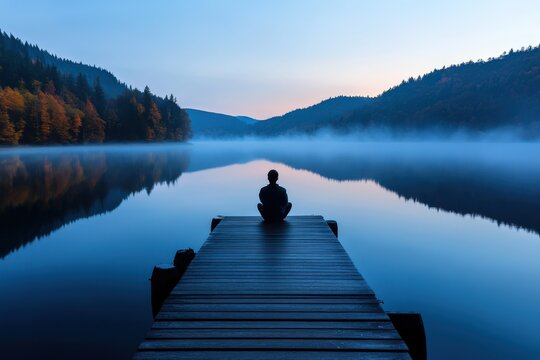

In [10]:
Image(input_image_url)

# Extra Analysis

In [12]:
# Step 6: Monitor GPU Usage (Optional)
print("GPU Usage:")
os.system("nvidia-smi")

GPU Usage:
Sun Nov 17 10:05:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             32W /  250W |    4743MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------------

0